In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
def load_data():
    data = sio.loadmat("../dataset/COVID19_Italy_train.mat")
    n = data["population"].reshape([])
    I, D, R = data["infectious"], data["death"], data["recovered"]
    I, D, R = I.reshape([-1, 1]), D.reshape([-1, 1]), R.reshape([-1, 1])
    t = np.arange(len(I)).astype(np.float32).reshape([-1, 1])
    # only consider the first 200 days, i.e. the first outbusrt of COVID-19
    return n, t[:200], I[:200], R[:200], D[:200]

In [3]:
def sird(t, u, beta, gamma, nu, N=None):
    I, R, D = tf.split(u, 3, axis=-1)
    S = N - I - R - D
    I_t = tf.gradients(I, t)[0]
    R_t = tf.gradients(R, t)[0]
    D_t = tf.gradients(D, t)[0]

    f1 = I_t - beta * I * S / N + gamma * I + nu * I
    f2 = R_t - gamma * I
    f3 = D_t - nu * I
    return tf.concat([f1, f2, f3], axis=-1)

In [4]:
def scaling(inputs, a=1, b=0):
    """Applies linear transformation, i.e. a*inputs + b."""
    return a * inputs + b

In [5]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, N, layers_u, layers_bgn):
    layers_beta = layers_gamma = layers_nu = layers_bgn
    # build processes
    input_scaling = lambda inputs: scaling(inputs, a=0.01)
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_u,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_u, mean=0, sigma=0.5),
    )
    process_beta = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_beta,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_beta, mean=0, sigma=1),
    )
    process_gamma = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_gamma,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_gamma, mean=0, sigma=1),
    )
    process_nu = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_nu,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        prior=neuq_vars.fnn.Samplable(layers=layers_nu, mean=0, sigma=1),
    )
    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=t_u_train, targets=u_train, processes=[process_u], sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_beta, process_gamma, process_nu],
        pde=lambda *args: sird(*args, N=N),
        sigma=0.02,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_beta, process_gamma, process_nu],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=2000,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=666,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: ", np.mean(results))

    processes = [process_u, process_beta, process_gamma, process_nu]
    return processes, samples, model

In [6]:
@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, N, layers_u, layers_bgn):
    layers_beta = layers_gamma = layers_nu = layers_bgn
    # build processes
    input_scaling = lambda inputs: scaling(inputs, a=0.01)
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_u,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_u),
    )
    process_beta = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_beta,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_beta),
    )
    process_gamma = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_gamma,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_gamma),
    )
    process_nu = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(
            layers=layers_nu,
            input_transform=input_scaling,
            output_transform=tf.math.softplus,  # to enforce positivity
        ),
        posterior=neuq_vars.fnn.Trainable(layers=layers_nu),
    )
    # build losses
    loss_u = neuq.likelihoods.MSE(
        inputs=t_u_train, targets=u_train, processes=[process_u], multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_beta, process_gamma, process_nu],
        pde=lambda *args: sird(*args, N=N),
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_beta, process_gamma, process_nu],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)

    processes = [process_u, process_beta, process_gamma, process_nu]
    return processes, samples, model

In [7]:
################## Load data and specify some hyperparameters ####################
n, t, I, R, D = load_data()
# use the first 160 days' data to train
t_train, I_train, R_train, D_train = t[:160], I[:160], R[:160], D[:160]
t_f_train, f_train = t_train.copy(), np.zeros_like(t_train)
t_test, I_test, R_test, D_test = t, I, R, D
# re-scaling
scale = 1e5
N = (n / scale).astype(np.float32)
I_train, R_train, D_train = I_train / scale, R_train / scale, D_train / scale
# t_train, I_train, R_train, D_train = t_train[::4], I_train[::4], R_train[::4], D_train[::4]
u_train = np.concatenate([I_train, R_train, D_train], axis=-1)

layers_u = [1, 100, 100, 3]  # layers for SIRD
layers_bgn = [1, 20, 1]  # layers for beta, gamma, and nu
noise = 0.1

In [8]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_train, u_train, t_f_train, f_train, noise, N, layers_u, layers_bgn,)

# processes, samples, model = Trainable(t_train, u_train, t_f_train, f_train, noise, N, layers_u, layers_bgn,)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate:  0.513
Execution time for 'Samplable' function is: 245.124 s, 4.085 mins


In [9]:
################################# Predictions ####################################
u_pred, beta_pred, gamma_pred, nu_pred = model.predict(t_test, samples, processes, pde_fn=None)
I_pred, R_pred, D_pred = np.split(u_pred, 3, axis=-1)

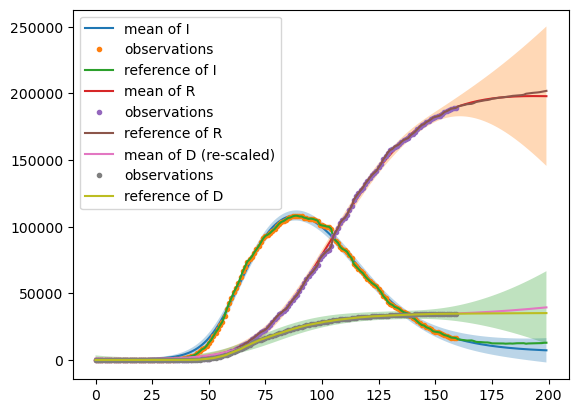

In [10]:
############################### Postprocessing ###################################
mu_I = np.mean(I_pred, axis=0) * scale
std_I = np.std(I_pred, axis=0) * scale
mu_R = np.mean(R_pred, axis=0) * scale
std_R = np.std(R_pred, axis=0) * scale
mu_D = np.mean(D_pred, axis=0) * scale
std_D = np.std(D_pred, axis=0) * scale
plt.plot(t_test, mu_I, label="mean of I")
plt.plot(t_train, I_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_I + 2 * std_I).reshape([-1]),
    (mu_I - 2 * std_I).reshape([-1]),
    alpha=0.3,
)
plt.plot(t_test, I, label="reference of I")
plt.plot(t_test, mu_R, label="mean of R")
plt.plot(t_train, R_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_R + 2 * std_R).reshape([-1]),
    (mu_R - 2 * std_R).reshape([-1]),
    alpha=0.3,

)
plt.plot(t_test, R, label="reference of R")
plt.plot(t_test, mu_D, label="mean of D (re-scaled)")
plt.plot(t_train, D_train * scale, ".", label="observations")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_D + 2 * std_D).reshape([-1]),
    (mu_D - 2 * std_D).reshape([-1]),
    alpha=0.3,
)
    
plt.plot(t_test, D, label="reference of D")
plt.legend()
plt.show()

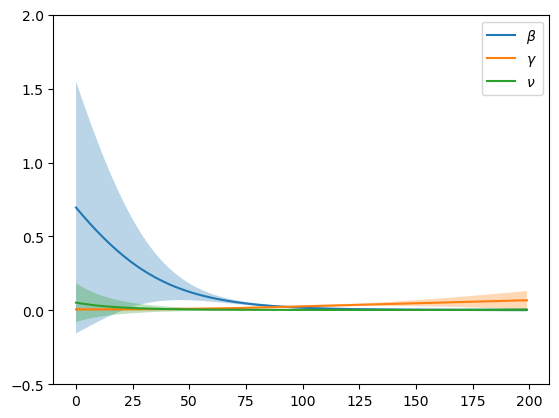

In [11]:
mu_gamma = np.mean(gamma_pred, axis=0)
std_gamma = np.std(gamma_pred, axis=0)
mu_beta = np.mean(beta_pred, axis=0)
std_beta = np.std(beta_pred, axis=0)
mu_nu = np.mean(nu_pred, axis=0)
std_nu = np.std(nu_pred, axis=0)

plt.plot(t_test, mu_beta, label="$\\beta$")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_beta + 2 * std_beta).reshape([-1]),
    (mu_beta - 2 * std_beta).reshape([-1]),
    alpha=0.3,
)

plt.plot(t_test, mu_gamma, label="$\\gamma$")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_gamma + 2 * std_gamma).reshape([-1]),
    (mu_gamma - 2 * std_gamma).reshape([-1]),
    alpha=0.3,
)
plt.plot(t_test, mu_nu, label="$\\nu$")
plt.fill_between(
    t_test.reshape([-1]),
    (mu_nu + 2 * std_nu).reshape([-1]),
    (mu_nu - 2 * std_nu).reshape([-1]),
    alpha=0.3,
)
plt.ylim([-0.5, 2])
plt.legend()
plt.show()

In [ ]:
# save data
# sio.savemat(
#     "./out/sird/DEns_dense.mat",
#     {
#         "t_test": t_test, "I_test": I, "R_test": R, "D_test": D,
#         "t_train": t_train, "I_train": I_train, "R_train": R_train, "D_train": D_train,
#         "I_pred": I_pred, "R_pred": R_pred, "D_pred": D_pred, "beta_pred": beta_pred,
#         "gamma_pred": gamma_pred, "nu_pred": nu_pred, "scale": scale, "noise": noise,
#     },
# )
